In [ ]:
# pip install -qq -U tensorflow-addons
!pip install einops

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from random import random
#vit libraries
import torch
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import ConcatDataset,Dataset
from torchvision.transforms import Resize, ToTensor
from einops import rearrange, reduce, repeat
from PIL import Image

In [4]:
NONTBI_folder = '/content/drive/MyDrive/NONTBI'
TBI_folder = '/content/drive/MyDrive/TBI'
NONTBI_names = sorted(os.listdir(NONTBI_folder))
TBI_names = sorted(os.listdir(TBI_folder))
print("NON TBI FILES:",len(NONTBI_names))
print("TBI FILES:", len(TBI_names))

NON TBI FILES: 69
TBI FILES: 72


In [5]:
class LazySignatureDataset(Dataset):
    def __init__(self, file_paths, class_label, transform=None):
        self.file_paths = file_paths
        self.class_label = class_label
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        img_path = self.file_paths[index]
        label = self.class_label

        # Load image only when needed
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
    
class GaussianBlur(object):
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, image):
        return image.filter(ImageFilter.GaussianBlur(self.radius))

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

to_tensor = [Resize((244, 244)), ToTensor()]
transform = Compose(to_tensor)

# Use specific files from forgery_files and real_files
TBI_files = ['/content/drive/MyDrive/TBI/' + file for file in TBI_names]
NONTBI_files = ['/content/drive/MyDrive/NONTBI/' + file for file in NONTBI_names]

# Create datasets using specific files
dataset_NONTBI = LazySignatureDataset(NONTBI_files, class_label=0, transform=transform)
dataset_TBI = LazySignatureDataset(TBI_files, class_label=1, transform=transform)

In [6]:
combined_dataset = ConcatDataset([dataset_NONTBI, dataset_TBI])
print(len(combined_dataset))

141


In [7]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 16, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

# Run a quick test
sample_datapoint = torch.unsqueeze(combined_dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


In [8]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [9]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [10]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [11]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [12]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [13]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [14]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [15]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=224, patch_size=16, emb_dim=128,
                n_layers=6, out_dim=2, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

In [22]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.9 * len(combined_dataset))
print(train_split,len(combined_dataset)-train_split)
train, test = random_split(combined_dataset, [train_split, len(combined_dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

126 15


In [23]:
import torch.optim as optim
import numpy as np

device = "cpu"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(101):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    if epoch % 2 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
        print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

>>> Epoch 0 train loss:  3.5315473675727844
>>> Epoch 0 test loss:  2.7210910320281982
>>> Epoch 25 train loss:  0.7604412138462067
>>> Epoch 25 test loss:  0.7540749907493591
>>> Epoch 50 train loss:  0.7139123678207397
>>> Epoch 50 test loss:  0.7178663611412048
>>> Epoch 75 train loss:  0.7058270871639252
>>> Epoch 75 test loss:  0.7101490497589111
>>> Epoch 100 train loss:  0.6998050212860107
>>> Epoch 100 test loss:  0.6926615238189697


In [24]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
# Get predicted classes
predicted_classes = outputs.argmax(dim=-1)

# Compare predicted classes with actual classes
correct_predictions = (predicted_classes == labels).sum().item()
print(predicted_classes)
print(labels)
# Calculate accuracy
accuracy = (correct_predictions / len(labels)) * 100

print("Accuracy: {:.2f}%".format(accuracy))

tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0])
Accuracy: 66.67%


In [25]:
torch.save(model.state_dict(), 'vit_model.pth')

In [26]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(labels,predicted_classes)

print("AUC Score:", auc_score)

AUC Score: 0.6607142857142857


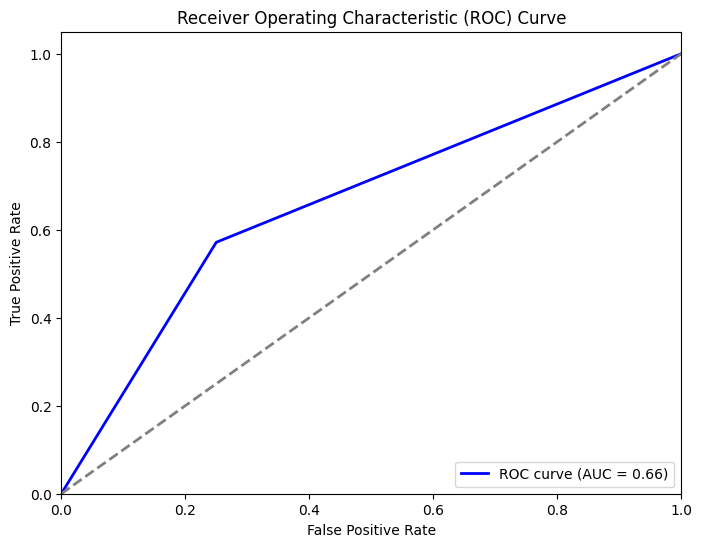

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(labels, predicted_classes)

# Compute AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()